Notebook where to plot the curves and display the performance of all models in 
a chosen folder. It is also where to conduct the performance analysis about the
models database.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpi
import json

from contrastive.utils.config import get_config_diff

## Function definitions

In [7]:
def exclude_conditions(diff_config, excluded_conditions):
    excluded_subdirs = []
    for cond in excluded_conditions:
        filtered_diff_config = diff_config.query(cond)
        excluded_subdirs.extend(filtered_diff_config['Unnamed: 0'].values)
    return excluded_subdirs
#exclude_conditions(diff_config, excluded_conditions=["lr != 0.0004"])

In [11]:
def show_results(dir_path, figsize=(16,10), return_config_diff=False, dataset='cingulate_ACCpatterns_0', excluded_conditions=[]):
    # be sure that all models are comparable
    get_config_diff(dir_path, whole_config=False)
    diff_config = pd.read_csv(dir_path+'/config_diff.csv')

    excluded_subdirs = exclude_conditions(diff_config, excluded_conditions)
    if excluded_conditions != []:
        print("Excluded subdirs :", excluded_subdirs)
        print("Excluded because of ", excluded_conditions)

    print(diff_config[~diff_config['Unnamed: 0'].isin(excluded_subdirs)])

    paths = []
    accuracy = []
    accuracy_std = []
    auc = []
    auc_std = []
    # plot all ROC curves
    for subdir in os.listdir(dir_path):
        if os.path.isdir(dir_path + '/' + subdir) and subdir not in excluded_subdirs:
            path = dir_path + '/' + subdir + '/' + dataset + '_embeddings'
            with open(path+'/values.json', 'r') as file:
                values = json.load(file)
            print(subdir)
            print("AUC", values['cross_val_auc'])
            img = mpi.imread(path+'/cross_val_ROC_curves.png')
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.show()

            # store the AUC and accuracy in a df
            paths.append(subdir)
            accuracy.append(values['cross_val_total_accuracy'][0])
            accuracy_std.append(values['cross_val_total_accuracy'][1])
            auc.append(values['cross_val_auc'][0])
            auc_std.append(values['cross_val_auc'][1])

    results_df = pd.DataFrame()
    results_df['path'] = paths
    results_df['auc'] = auc
    results_df['auc_std'] = auc_std
    results_df['accuracy'] = accuracy
    results_df['accuracy_std'] = accuracy_std


    if return_config_diff:
        return results_df, diff_config
    else:
        return results_df

## Resume the results

Empty DataFrame
Columns: [Unnamed: 0]
Index: []
10
AUC [0.547601081234884, 0.07375381137252042]


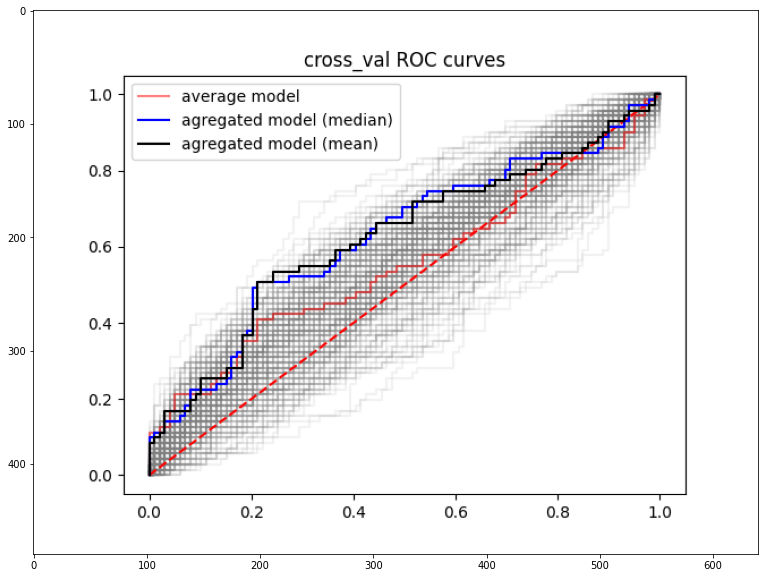

30
AUC [0.5869978659837815, 0.05542486780161764]


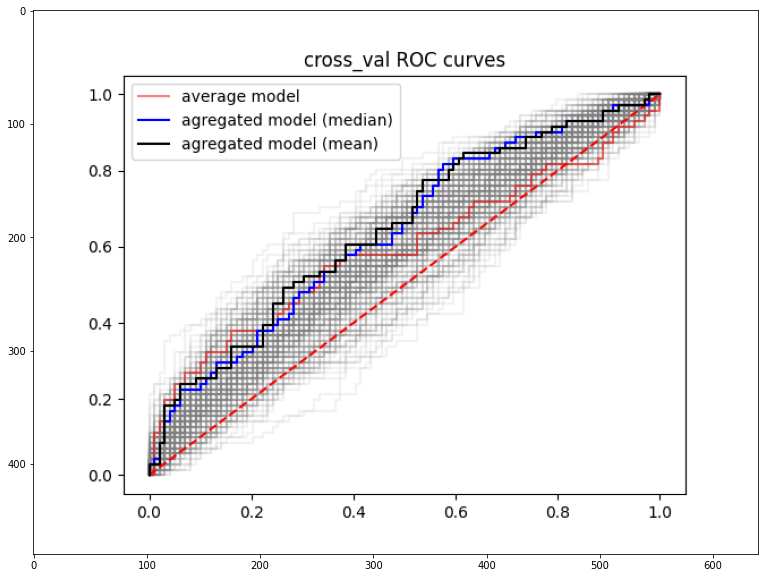

4
AUC [0.537138711054204, 0.0968772397725285]


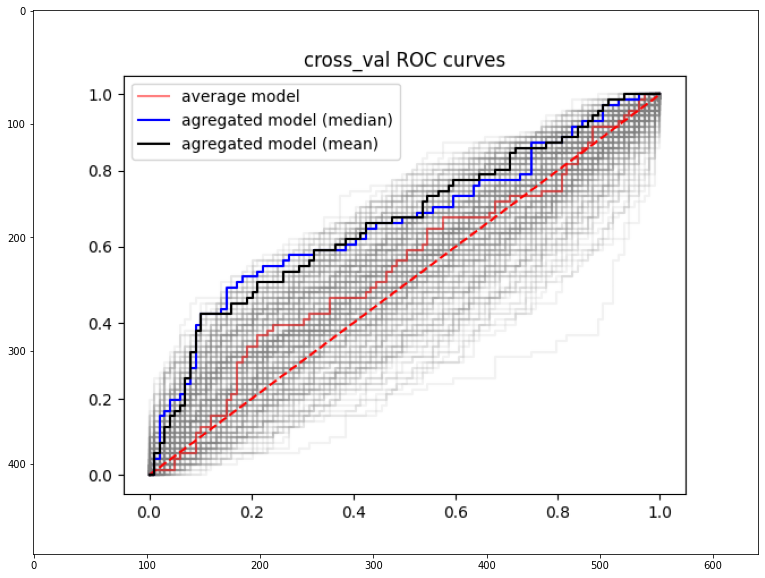

,path,auc,auc_std,accuracy,accuracy_std
0,10,0.547601,0.073754,0.553600,0.054704
1,30,0.586998,0.055425,0.577365,0.041588
2,4,0.537139,0.096877,0.547271,0.064675


In [12]:
excluded_conditions = []

results_df = show_results(
    dir_path="/neurospin/dico/data/deep_folding/papers/ipmi2023/models/PCA",
    dataset='cingulate_ACCpatterns_0',
    excluded_conditions=excluded_conditions)

results_df

In [13]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
1,30,0.586998
0,10,0.547601
2,4,0.537139


In [14]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']].mean()

path    10034.666667
auc         0.557246
dtype: float64

## Analysis of old Aymeric gridsearch

In [15]:
# directories are supposed to have a certain structure and name patterns
def get_results_table(dir_path, model_types=['convnet', 'densenet2'], verbose=False):
    results = {k: {} for k in model_types}

    for model_type in os.listdir(dir_path):
        if model_type in model_types:
            if verbose:
                print(model_type)
            path = os.path.join(dir_path, model_type)
            for params in os.listdir(path):
                params_path = os.path.join(path, params)
                if os.path.isdir(params_path):
                    if verbose:
                        print(params)
                    
                    n_models = 0

                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = 0
                        results[model_type]['no_foldlabel_'+params] = 0
                    else:    
                        results[model_type][params] = 0
                    
                    for model in os.listdir(params_path):
                        model_path = os.path.join(params_path, model)
                        # start a model name by & to filter it out of the performance analysis
                        if os.path.isdir(model_path) and model[0] != '&':
                            if verbose:
                                print(model)

                            n_models += 1

                            if model_type == 'pca':
                                values = os.path.join(params_path, model, 'values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type]['foldlabel_'+params] += values['cross_val_auc'][0]
                                results[model_type]['no_foldlabel_'+params] += values['cross_val_auc'][0]
                            else:
                                values = os.path.join(params_path, model, 'cingulate_ACCpatterns_embeddings/values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type][params] += values['cross_val_auc'][0]
                    
                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = results[model_type]['foldlabel_'+params]/n_models
                        results[model_type]['no_foldlabel_'+params] = results[model_type]['no_foldlabel_'+params]/n_models
                    else:
                        results[model_type][params] = results[model_type][params]/n_models
    
    results_df = pd.DataFrame(results)
    results_df.sort_index(inplace=True)
    return results_df

In [16]:
dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders"
results_df = get_results_table(dir_path, model_types=['convnet', 'densenet2', 'pca'])

results_df.to_csv("/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/performance_comparison_5000.csv")

results_df

,convnet,densenet2,pca
foldlabel_30,0.613729,0.658608,0.595418
foldlabel_4,0.589703,0.574395,0.538784
no_foldlabel_30,0.649748,0.575910,0.595418
no_foldlabel_4,0.514435,0.488433,0.538784
